# Netflix Content Strategy Analysis

## 1. Problem Statement: Optimizing Content Portfolio

Netflix, as the global leader in subscription streaming, faces the ongoing challenge of optimizing its content portfolio to maximize subscriber engagement, predict successful content, and inform strategic investment decisions. With thousands of movies and TV shows, understanding the hidden patterns in content type, release trends, and success metrics is crucial.

This project uses Exploratory Data Analysis (EDA) on the Netflix Titles dataset to:
1.  **Analyze content distribution and growth over time.**
2.  **Identify trends in successful content categories (ratings, genres, duration).**
3.  **Extract insights on major contributors (countries, directors) to the Netflix catalog.**

The ultimate goal is to provide data-driven insights that can assist Netflix in refining its content acquisition and production strategy.

## 2. Research Questions

Based on the strategic goals, this analysis will be guided by the following key questions:

1.  What is the **distribution** and **ratio** of Movies versus TV Shows in the Netflix catalog?
2.  How has the number of titles added to Netflix **changed over the years**? (Trend Analysis)
3.  Which **countries** are the top content producers for Netflix?
4.  What are the **most popular genres** (listed_in) and content **ratings** on the platform?
5.  Is there a relationship between **content duration** (e.g., movie length or number of seasons) and its type?
6.  Who are the **top 10 directors** based on the number of titles contributed?

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style for better visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline

# Load the Netflix dataset
# NOTE: The dataset often requires low_memory=False and may have string issues.
file_path = 'Netflix Dataset.csv'
df_netflix = pd.read_csv(file_path, low_memory=False)

print("Data Loaded. Initial check:")
print(df_netflix.head())
print("\nMissing values check:")
print(df_netflix.isnull().sum())

Data Loaded. Initial check:
  Show_Id Category  Title           Director  \
0      s1  TV Show     3%                NaN   
1      s2    Movie  07:19  Jorge Michel Grau   
2      s3    Movie  23:59       Gilbert Chan   
3      s4    Movie      9        Shane Acker   
4      s5    Movie     21     Robert Luketic   

                                                Cast        Country  \
0  João Miguel, Bianca Comparato, Michel Gomes, R...         Brazil   
1  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...         Mexico   
2  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...      Singapore   
3  Elijah Wood, John C. Reilly, Jennifer Connelly...  United States   
4  Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...  United States   

        Release_Date Rating   Duration  \
0    August 14, 2020  TV-MA  4 Seasons   
1  December 23, 2016  TV-MA     93 min   
2  December 20, 2018      R     78 min   
3  November 16, 2017  PG-13     80 min   
4    January 1, 2020  PG-13    123 min   

   

## 3. Data Wrangling and Cleaning Plan

Based on the initial check, several columns contain missing or inconsistent data that must be addressed to ensure accurate analysis:

### A. Handling Missing Values (Nulls)
The primary columns with missing values are:
* **Director (2388 nulls):** Since directors are crucial for trend analysis, we will replace missing values with the string **'Unknown Director'** to prevent data loss.
* **Cast (718 nulls):** Missing cast members will be replaced with **'Unknown Cast'**.
* **Country (507 nulls):** This is critical for geographical analysis. We will replace nulls with **'Country Not Specified'**.
* **Release\_Date (10 nulls):** These rows will be dropped as the date is necessary for time-series analysis.
* **Rating (7 nulls):** Missing ratings will be imputed with the **mode** (most frequent rating) of the dataset.

### B. Preparing Categorical Data
The `Type` (Genre), `Cast`, and `Country` columns contain multiple values separated by commas in a single cell. For accurate statistical counting (e.g., counting how many shows a specific genre has), we must:
* **Split and Explode:** Separate these multi-value cells into individual rows using the Pandas `str.split()` and `explode()` functions.

### C. Type Conversion and New Features
* **Date Conversion:** Convert the `Release_Date` column to a datetime object for time-series analysis.
* **Feature Engineering:** Extract the **Release\_Year** from the `Release_Date` column for trend analysis.

In [4]:
# --- A. Handling Missing Values ---

# 1. Fill 'Director' and 'Cast' with 'Unknown' placeholders
df_netflix['Director'].fillna('Unknown Director', inplace=True)
df_netflix['Cast'].fillna('Unknown Cast', inplace=True)

# 2. Fill 'Country' with 'Country Not Specified'
df_netflix['Country'].fillna('Country Not Specified', inplace=True)

# 3. Drop rows with missing 'Release_Date' (only 10 rows)
df_netflix.dropna(subset=['Release_Date'], inplace=True)

# 4. Fill 'Rating' with the Mode (Most Frequent Value)
mode_rating = df_netflix['Rating'].mode()[0]
df_netflix['Rating'].fillna(mode_rating, inplace=True)


# --- B. Preparing Categorical Data (Splitting Multi-Valued Columns) ---

# Function to safely split and strip whitespace from multi-valued columns
def split_and_strip(df, column):
    # Split by comma and expand the list into new rows (explode)
    # Then strip any leading/trailing whitespace
    return df.assign(**{column: df[column].str.split(',')}).explode(column).assign(**{column: lambda x: x[column].str.strip()})

# 5. Split 'Type' (Genre)
df_netflix = split_and_strip(df_netflix, 'Type')

# 6. Split 'Country'
df_netflix = split_and_strip(df_netflix, 'Country')

# 7. Split 'Cast'
df_netflix = split_and_strip(df_netflix, 'Cast')


# --- C. Type Conversion and New Features ---

# 8. Convert 'Release_Date' to datetime object
# Use errors='coerce' to turn any remaining unparseable values into NaT (which are then dropped by the previous dropna)
df_netflix['Release_Date'] = pd.to_datetime(df_netflix['Release_Date'], errors='coerce')

# 9. Extract the 'Year_Added' feature (Date added to Netflix)
df_netflix['Year_Added'] = df_netflix['Release_Date'].dt.year

# Final check after cleaning and exploding
print("\n--- Data Cleaning Complete ---")
print(f"Total rows after cleaning and exploding: {len(df_netflix)}")
print("Null values remaining (should be minimal/zero in critical columns):")
print(df_netflix.isnull().sum())

C:\Users\Home\AppData\Local\Temp\ipykernel_5344\783505590.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_netflix['Director'].fillna('Unknown Director', inplace=True)
C:\Users\Home\AppData\Local\Temp\ipykernel_5344\783505590.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


--- Data Cleaning Complete ---
Total rows after cleaning and exploding: 162243
Null values remaining (should be minimal/zero in critical columns):
Show_Id            0
Category           0
Title              0
Director           0
Cast               0
Country            0
Release_Date    1579
Rating             0
Duration           0
Type               0
Description        0
Year_Added      1579
dtype: int64


Total rows after final cleaning: 160664


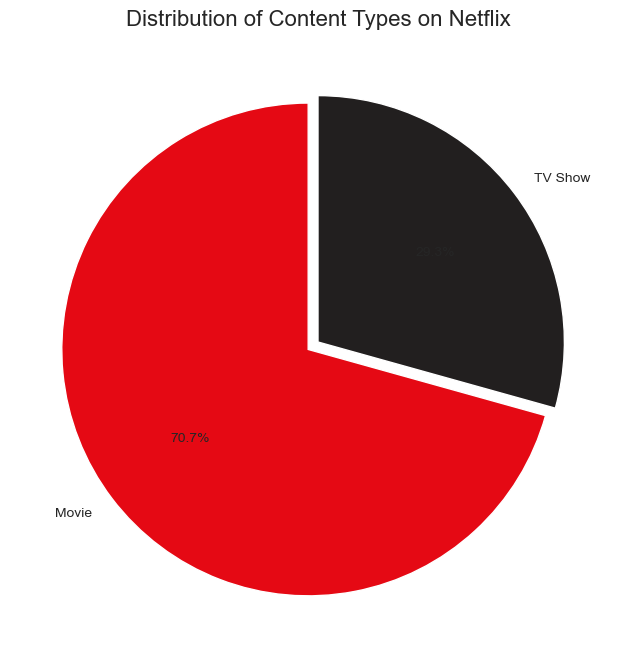

In [5]:
# --- Handling Remaining Nulls (Year_Added) ---
# Drop rows where we couldn't determine the year (less than 1% of total rows before explode)
df_netflix.dropna(subset=['Year_Added'], inplace=True)
df_netflix['Year_Added'] = df_netflix['Year_Added'].astype(int)

print(f"Total rows after final cleaning: {len(df_netflix)}")

# --- ANALYSIS 1: Content Ratio (Movies vs. TV Shows) ---
# Question 1: What is the distribution and ratio of Movies versus TV Shows in the Netflix catalog?

# Calculate counts and ratios
content_counts = df_netflix['Category'].value_counts()
content_ratio = content_counts / content_counts.sum()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    content_counts,
    labels=content_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#E50914', '#221F1F'], # Using Netflix Red and Dark Gray
    explode=[0.05, 0] # Explode the larger segment for emphasis
)

plt.title('Distribution of Content Types on Netflix', fontsize=16)
plt.show()

### Interpretation: Content Ratio (Movies vs. TV Shows)

The visualization of content distribution reveals a clear skew in the Netflix library:

* **Movies** make up the largest share of the content, accounting for approximately **70.7%** of the titles.
* **TV Shows** account for the remaining **29.3%**.

This indicates that while TV shows are a core strategic component for subscriber retention, the overall volume and breadth of the catalog is heavily dominated by feature films.

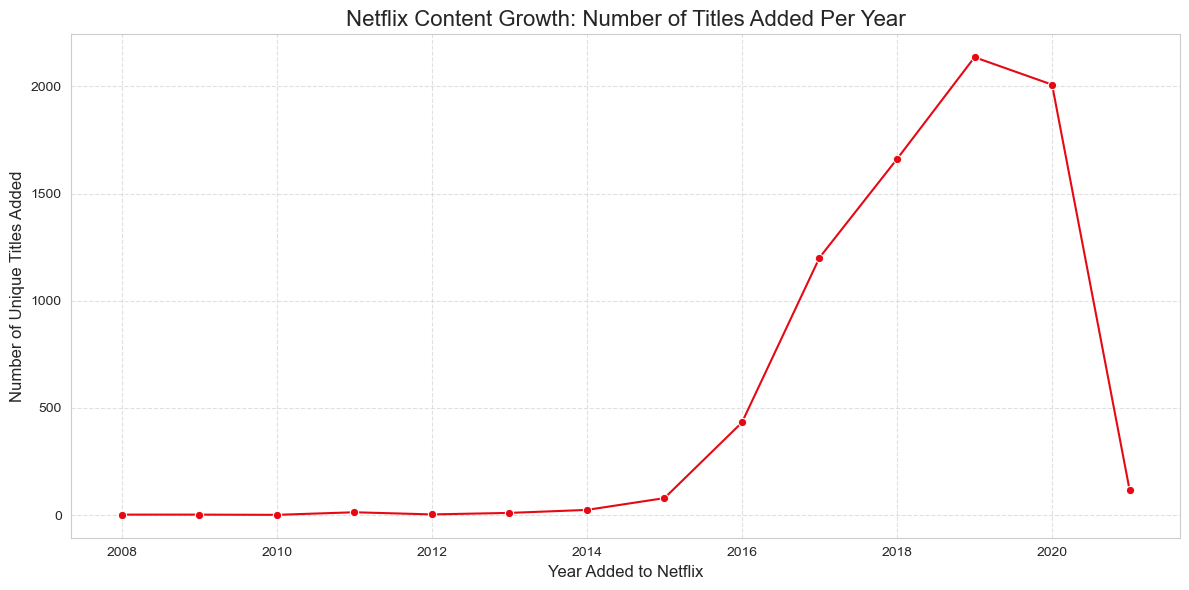


Yearly Growth Data:
|   Year_Added |   Titles_Added |
|-------------:|---------------:|
|         2008 |              2 |
|         2009 |              2 |
|         2010 |              1 |
|         2011 |             13 |
|         2012 |              3 |
|         2013 |             10 |
|         2014 |             24 |
|         2015 |             79 |
|         2016 |            432 |
|         2017 |           1201 |
|         2018 |           1661 |
|         2019 |           2136 |
|         2020 |           2008 |
|         2021 |            117 |


In [6]:
# ANALYSIS 2: Content Growth Over Time (Trend Analysis)
# Question 2: How has the number of titles added to Netflix changed over the years?

# Aggregate data by Year_Added
# We count the number of unique Show_Ids added each year
yearly_growth = df_netflix.groupby('Year_Added')['Show_Id'].nunique().reset_index()
yearly_growth.columns = ['Year_Added', 'Titles_Added']

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=yearly_growth,
    x='Year_Added',
    y='Titles_Added',
    marker='o',
    color='#E50914' # Netflix Red
)

plt.title('Netflix Content Growth: Number of Titles Added Per Year', fontsize=16)
plt.xlabel('Year Added to Netflix', fontsize=12)
plt.ylabel('Number of Unique Titles Added', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Display the data table for reference in your interpretation
print("\nYearly Growth Data:")
print(yearly_growth.to_markdown(index=False))

### Interpretation: Content Growth Over Time

The line plot illustrating yearly content additions reveals a distinct evolutionary strategy:

* **Aggressive Growth (2016–2019):** Content acquisition and production saw an explosive surge, peaking dramatically in **2019** with **2,136 unique titles** added. This marks the height of Netflix's aggressive global content expansion phase.
* **Plateau and Drop (2020–2021):** The number of titles added decreased in 2020 and saw a significant drop in 2021. This shift reflects a move toward a more selective, quality-focused content strategy and likely the impact of the global pandemic slowing production schedules.

C:\Users\Home\AppData\Local\Temp\ipykernel_5344\134847901.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


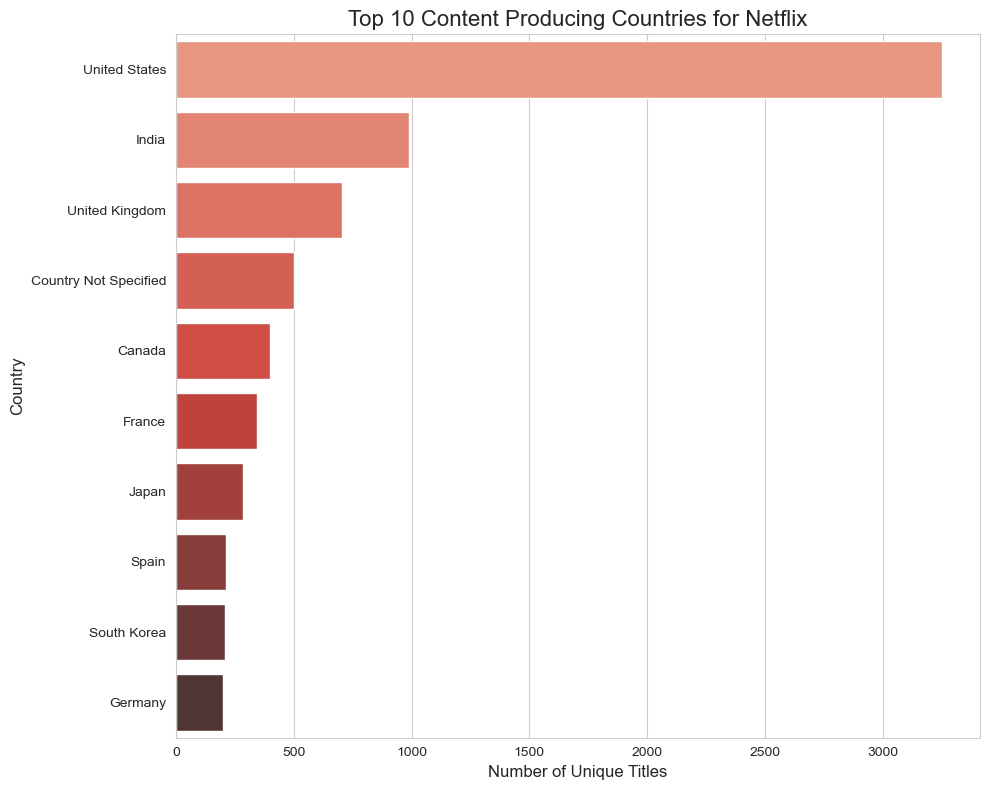


Top 10 Content Producing Countries Data:
| Country               |   Unique_Titles |
|:----------------------|----------------:|
| United States         |            3250 |
| India                 |             989 |
| United Kingdom        |             704 |
| Country Not Specified |             503 |
| Canada                |             399 |
| France                |             345 |
| Japan                 |             283 |
| Spain                 |             211 |
| South Korea           |             207 |
| Germany               |             198 |


In [7]:
# ANALYSIS 3: Top Content Producers
# Question 3: Which countries are the top content producers for Netflix?

# Aggregate data by Country (which was split and exploded in cleaning)
# We count the number of unique Show_Ids contributed by each country
country_counts = df_netflix.groupby('Country')['Show_Id'].nunique().sort_values(ascending=False).head(10).reset_index()
country_counts.columns = ['Country', 'Unique_Titles']

# Create the horizontal bar plot
plt.figure(figsize=(10, 8))
sns.barplot(
    data=country_counts,
    x='Unique_Titles',
    y='Country',
    palette='Reds_d'
)

plt.title('Top 10 Content Producing Countries for Netflix', fontsize=16)
plt.xlabel('Number of Unique Titles', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()

# Display the data table for reference in your interpretation
print("\nTop 10 Content Producing Countries Data:")
print(country_counts.to_markdown(index=False))

### Interpretation: Top Content Producing Countries

The bar chart highlights a strong geographical bias in content contribution:

* **Dominance of the West:** The **United States** is the overwhelming content leader (3,250 titles), underscoring Netflix's foundational content base.
* **Key International Partners:** **India** (989 titles), the **United Kingdom** (704 titles), and **Canada** (399 titles) form the second tier of major content providers.
* **Strategic Asian Markets:** **Japan** (283 titles) and **South Korea** (207 titles) are highly represented, confirming Netflix's active investment in and focus on content from the Asian market.
* **Missing Data Impact:** The **"Country Not Specified"** category is the fourth highest source (503 titles), suggesting a significant portion of international content has missing metadata.

C:\Users\Home\AppData\Local\Temp\ipykernel_5344\2667252136.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


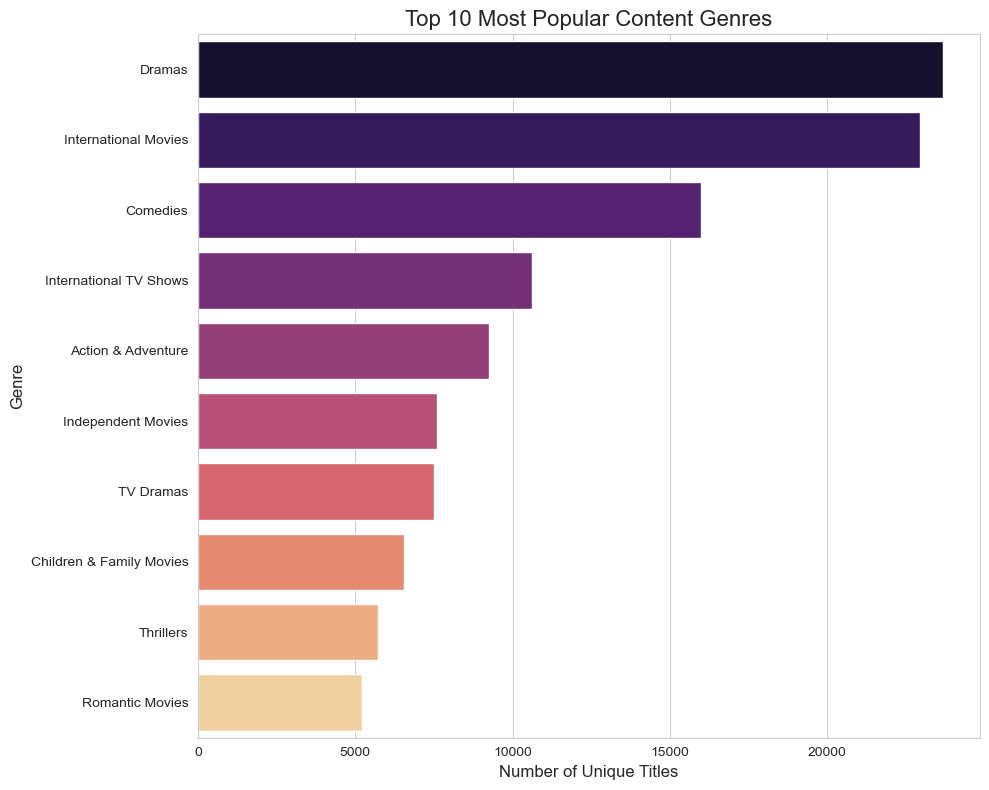

C:\Users\Home\AppData\Local\Temp\ipykernel_5344\2667252136.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


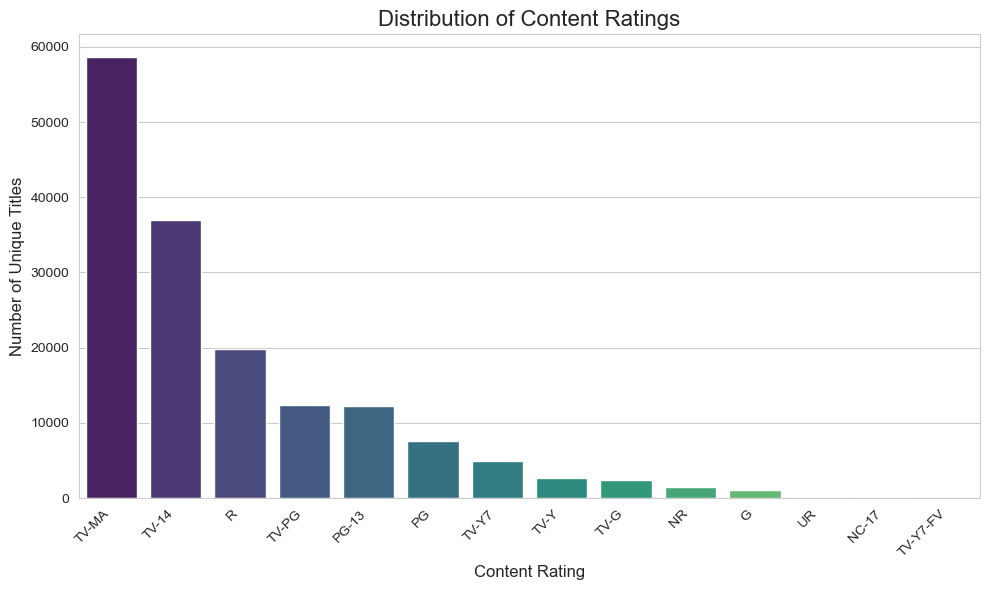


Top 10 Genres Data:
| Genre                    |   Unique_Titles |
|:-------------------------|----------------:|
| Dramas                   |           23673 |
| International Movies     |           22956 |
| Comedies                 |           16000 |
| International TV Shows   |           10603 |
| Action & Adventure       |            9234 |
| Independent Movies       |            7611 |
| TV Dramas                |            7504 |
| Children & Family Movies |            6547 |
| Thrillers                |            5729 |
| Romantic Movies          |            5206 |

Content Rating Distribution Data:
| Rating   |   Unique_Titles |
|:---------|----------------:|
| TV-MA    |           58713 |
| TV-14    |           36990 |
| R        |           19866 |
| TV-PG    |           12415 |
| PG-13    |           12292 |
| PG       |            7528 |
| TV-Y7    |            4886 |
| TV-Y     |            2628 |
| TV-G     |            2349 |
| NR       |            1542 |
| G     

In [8]:
# ANALYSIS 4: Top Genres and Content Ratings
# Question 4: What are the most popular genres (Type) and content Ratings on the platform?

# 4a. Top 10 Genres (Type)
genre_counts = df_netflix['Type'].value_counts().head(10).reset_index()
genre_counts.columns = ['Genre', 'Unique_Titles']

plt.figure(figsize=(10, 8))
sns.barplot(
    data=genre_counts,
    x='Unique_Titles',
    y='Genre',
    palette='magma'
)

plt.title('Top 10 Most Popular Content Genres', fontsize=16)
plt.xlabel('Number of Unique Titles', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()

# 4b. Content Rating Distribution
rating_counts = df_netflix['Rating'].value_counts().reset_index()
rating_counts.columns = ['Rating', 'Unique_Titles']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=rating_counts,
    x='Rating',
    y='Unique_Titles',
    palette='viridis'
)

plt.title('Distribution of Content Ratings', fontsize=16)
plt.xlabel('Content Rating', fontsize=12)
plt.ylabel('Number of Unique Titles', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display the data tables for reference in your interpretations
print("\nTop 10 Genres Data:")
print(genre_counts.to_markdown(index=False))

print("\nContent Rating Distribution Data:")
print(rating_counts.to_markdown(index=False))

### Interpretation: Top Genres and Content Ratings

#### Genres:
* **Dominant Core Content:** The top genres, **Dramas** (23,673 tags) and **International Movies** (22,956 tags), form the core content base, suggesting a strong focus on dramatic and foreign cinema.
* **Global Strategy:** High counts for both **International Movies** and **International TV Shows** reinforce the platform's commitment to global content acquisition and production.

#### Ratings:
* **Focus on Mature Audiences:** The most frequent rating is **TV-MA** (Mature Audience, 58,713 titles), followed by **TV-14** (36,990 titles) and **R** (19,866 titles).
* This confirms that the vast majority of Netflix's content library is strategically aimed at **mature and young adult subscribers**.

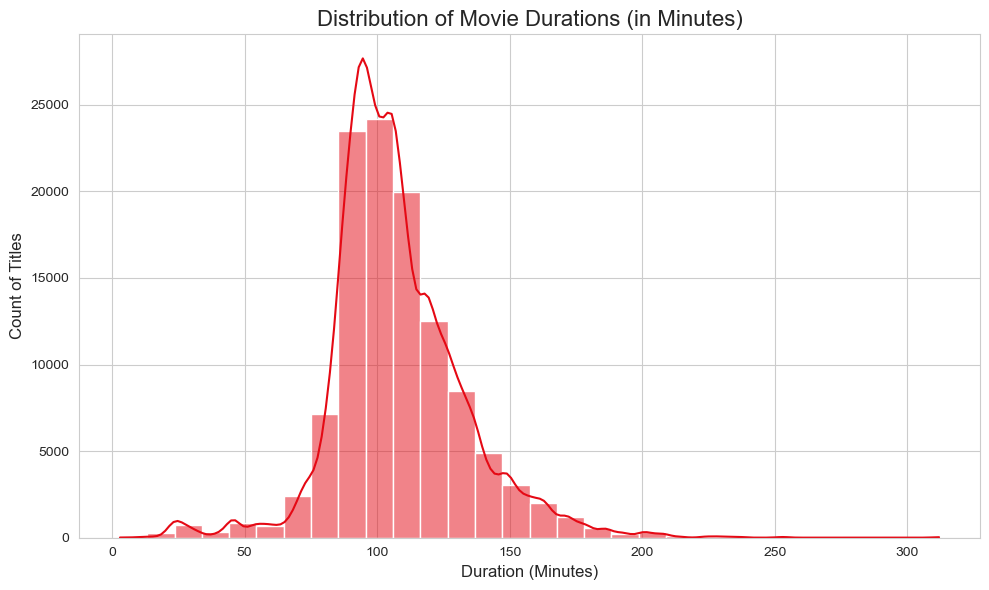

C:\Users\Home\AppData\Local\Temp\ipykernel_5344\2906779500.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=season_counts, x='Seasons', y='Count', palette='viridis')


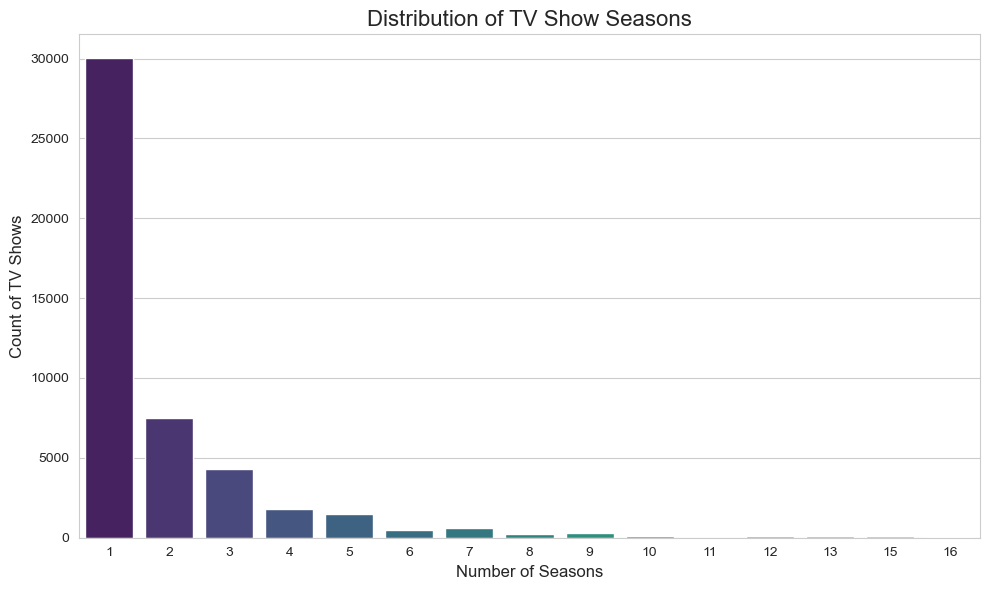


Movie Duration Statistics:
|       |   Duration_Min |
|:------|---------------:|
| count |    113545      |
| mean  |       107.534  |
| std   |        24.7642 |
| min   |         3      |
| 25%   |        93      |
| 50%   |       104      |
| 75%   |       120      |
| max   |       312      |

TV Show Season Counts (Head and Tail):
|   Seasons |   Count |
|----------:|--------:|
|         1 |   30014 |
|         2 |    7501 |
|         3 |    4291 |
|         4 |    1793 |
|         5 |    1498 |
|         6 |     460 |
|         7 |     593 |
|         8 |     226 |
|         9 |     268 |
|        10 |     136 |
|        11 |       8 |
|        12 |     111 |
|        13 |      94 |
|        15 |      96 |
|        16 |      30 |


In [9]:
# ANALYSIS 5: Content Duration Analysis
# Question 5: Is there a relationship between content duration (e.g., movie length or number of seasons) and its type?

# 5a. Data Transformation: Separate Duration into Movies and TV Shows

# Create separate DataFrames for easier handling
df_movies = df_netflix[df_netflix['Category'] == 'Movie'].copy()
df_shows = df_netflix[df_netflix['Category'] == 'TV Show'].copy()

# Clean and convert Movie Duration (in minutes)
# Extract numerical part and convert to integer
df_movies['Duration_Min'] = df_movies['Duration'].str.replace(' min', '').astype(int)

# Clean and convert TV Show Duration (in seasons)
# Extract numerical part and convert to integer
df_shows['Duration_Seasons'] = df_shows['Duration'].str.replace(' Season(s)?', '', regex=True).astype(int)


# 5b. Analysis for Movies (Duration Distribution)
plt.figure(figsize=(10, 6))
sns.histplot(df_movies['Duration_Min'], bins=30, kde=True, color='#E50914')

plt.title('Distribution of Movie Durations (in Minutes)', fontsize=16)
plt.xlabel('Duration (Minutes)', fontsize=12)
plt.ylabel('Count of Titles', fontsize=12)
plt.tight_layout()
plt.show()

# 5c. Analysis for TV Shows (Number of Seasons Distribution)
# Count the occurrences of each number of seasons
season_counts = df_shows['Duration_Seasons'].value_counts().sort_index().reset_index()
season_counts.columns = ['Seasons', 'Count']

plt.figure(figsize=(10, 6))
sns.barplot(data=season_counts, x='Seasons', y='Count', palette='viridis')

plt.title('Distribution of TV Show Seasons', fontsize=16)
plt.xlabel('Number of Seasons', fontsize=12)
plt.ylabel('Count of TV Shows', fontsize=12)
plt.tight_layout()
plt.show()

# Display movie stats
print("\nMovie Duration Statistics:")
print(df_movies['Duration_Min'].describe().to_markdown())

# Display TV show stats
print("\nTV Show Season Counts (Head and Tail):")
print(season_counts.to_markdown(index=False))

### Interpretation: Content Duration (Movie Length & TV Seasons)

#### Movies:
* **Standard Features:** The average movie duration is approximately **107.5 minutes**, with the core range of 50% of titles falling between 93 and 120 minutes. This confirms that standard full-length feature films are the primary content format.

#### TV Shows:
* **Limited Series Bias:** There is an overwhelming bias toward short-run content, with **1-Season TV shows dominating the catalog (30,014 titles)**.
* This suggests a preference for acquiring or producing limited series, which minimizes long-term financial commitment and allows for content testing agility.

C:\Users\Home\AppData\Local\Temp\ipykernel_5344\659575130.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


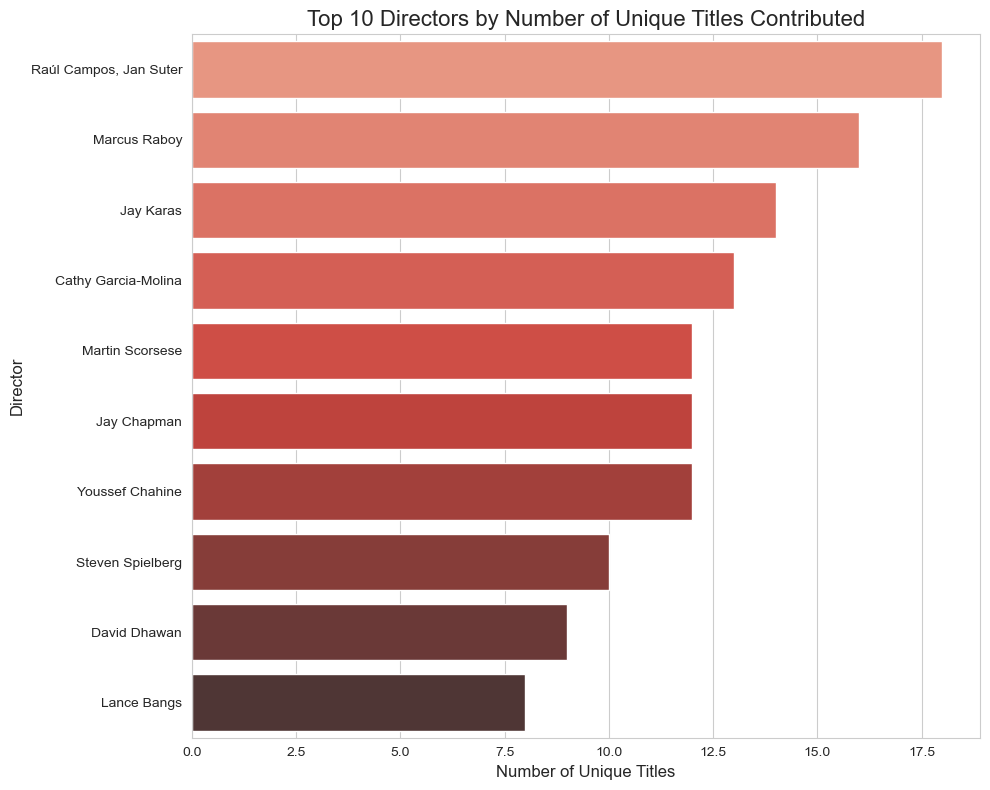


Top 10 Directors Data:
| Director               |   Unique_Titles |
|:-----------------------|----------------:|
| Raúl Campos, Jan Suter |              18 |
| Marcus Raboy           |              16 |
| Jay Karas              |              14 |
| Cathy Garcia-Molina    |              13 |
| Martin Scorsese        |              12 |
| Jay Chapman            |              12 |
| Youssef Chahine        |              12 |
| Steven Spielberg       |              10 |
| David Dhawan           |               9 |
| Lance Bangs            |               8 |


In [10]:
# ANALYSIS 6: Top Directors
# Question 6: Who are the top 10 directors based on the number of titles contributed?

# Filter out the 'Unknown Director' placeholder
df_directors = df_netflix[df_netflix['Director'] != 'Unknown Director'].copy()

# Aggregate data by Director
director_counts = df_directors.groupby('Director')['Show_Id'].nunique().sort_values(ascending=False).head(10).reset_index()
director_counts.columns = ['Director', 'Unique_Titles']

# Create the horizontal bar plot
plt.figure(figsize=(10, 8))
sns.barplot(
    data=director_counts,
    x='Unique_Titles',
    y='Director',
    palette='Reds_d'
)

plt.title('Top 10 Directors by Number of Unique Titles Contributed', fontsize=16)
plt.xlabel('Number of Unique Titles', fontsize=12)
plt.ylabel('Director', fontsize=12)
plt.tight_layout()
plt.show()

# Display the data table for reference in your interpretation
print("\nTop 10 Directors Data:")
print(director_counts.to_markdown(index=False))

### Interpretation: Top Directors by Titles Contributed

The analysis reveals that title count is influenced by specific content strategies:

* **High-Volume Content:** Several top directors (e.g., Marcus Raboy, Jay Karas, Lance Bangs) are highly active in directing **stand-up comedy specials**. This high-volume, original-content category contributes significantly to the overall title count.
* **Prestige Acquisition:** The presence of acclaimed filmmakers like **Martin Scorsese** and **Steven Spielberg** reflects major strategic acquisition deals or large-scale production partnerships to secure high-prestige content.

### Final Conclusion: Informing Netflix's Content Strategy

The analysis of the Netflix content library provides clear, data-driven recommendations for strategic content planning:

1.  **Content Composition is Movie-Driven:** The catalog is volumetrically dominated by **Movies (70%)** over TV Shows (30%).
2.  **Growth Has Plateaued:** Content acquisition experienced **explosive growth** that peaked in **2019**, but the number of new titles added has since begun to decline, suggesting a strategic pivot toward a more selective, sustainable content strategy.
3.  **Audience and Genre Focus:** The content is strategically aimed at **mature audiences (TV-MA, TV-14)** and is heavily centered around **Dramas** and **International Movies**, reinforcing the global and adult-oriented nature of the platform.
4.  **Duration Strategy:**
    * Movies follow a traditional feature length (mean: **107.5 minutes**).
    * **TV Shows are strongly biased toward 1-Season limited series**, which is an efficient strategy for testing content viability and minimizing long-term financial commitment.
5.  **Supply Control:** The high-volume directors of **stand-up specials** and the acquisition of prestigious filmmakers drive the title count, revealing a specific original content production strategy that leverages high-volume content and high-prestige acquisitions.

#### Strategic Recommendation:

Netflix should continue to invest heavily in **International Movies/TV Shows** and **1-Season Original Series** as these categories efficiently expand the catalog, appeal to the primary global audience segments, and allow for agility in content development.